In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

In [22]:
dataset = pd.read_csv('hmnist_28_28_RGB.csv', delimiter=',',nrows=None)
dataset.dataframeName = 'hmnist_28_28_RGB.csv'
numRow, numCol = dataset.shape
print(f"The total rows of dataset:{numRow}")
print(f"The total columns of dataset:{numCol}")

The total rows of dataset:10015
The total columns of dataset:2353


In [ ]:
# Here each image is separated into 2352 different pixel values and the last column is the image label.
dataset.head(5)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

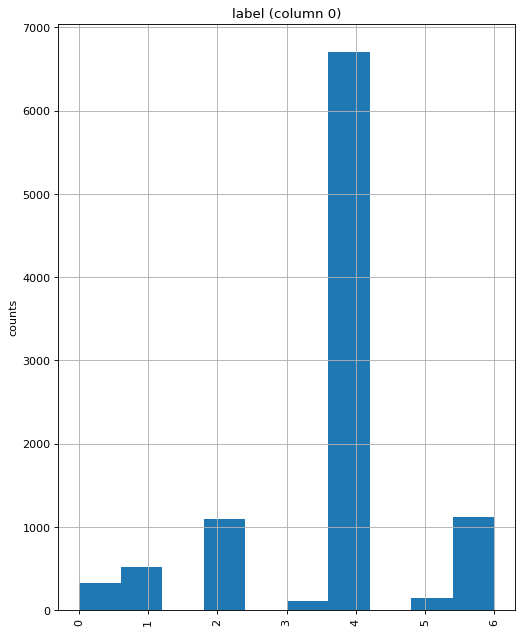

labels: [2 4 3 6 5 1 0]


In [ ]:
# Here we can see ther are 7 different labels inside the dataset.
plotPerColumnDistribution(dataset, 10, 5)
print("labels:",dataset.label.unique())

In [23]:
# Now get the different labels. Based on the dicussion on https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
classes={0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),
     1:('bcc' , 'basal cell carcinoma'),
     2:('bkl', 'benign keratosis-like lesions'),
     3:('df', 'dermatofibroma'),
     4:('nv', ' melanocytic nevi'),
     5:('vasc', ' pyogenic granulomas and hemorrhage'),
     6:('mel', 'melanoma'),}

In [24]:
# Now separate the train and test sets.
train, test = train_test_split(dataset, test_size=0.2, random_state=2023)
X_train = train.iloc[:, :-1]
Y_train = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
Y_test = test.iloc[:, -1]
print("Training X:", X_train.shape)
print("Training Y:", Y_train.shape)
print("Test X:", X_test.shape)
print("Test Y:", Y_test.shape)

Training X: (8012, 2352)
Training Y: (8012,)
Test X: (2003, 2352)
Test Y: (2003,)


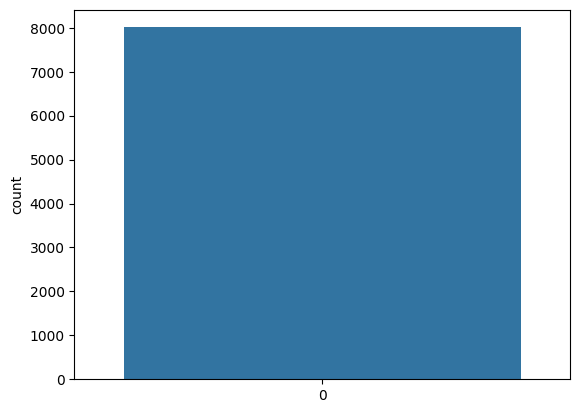

In [25]:
# From the Label diagram. We can see that this dataset is imbalanced with label 4 has over 6500 data.
# So here we need to balancing the data.
sns.countplot(Y_train)
oversample = RandomOverSampler()


<Axes: ylabel='count'>

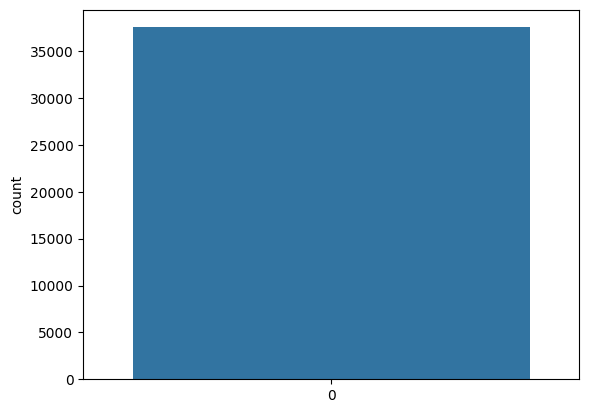

In [26]:
# now the data are balancing with close amount.
X_train,Y_train = oversample.fit_resample(X_train,Y_train)
sns.countplot(Y_train)

In [27]:
# Now build up the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
# -------------------------------------------------------------------------------
# [1] model, based on the proposal.
# Good thing: Run fast. The test error is not that low. 71%
# Bad thing: Cannot do well in the cross validation during traning model. High validation loss and accuarcy.
# model1 = Sequential()
# for _ in range(4):
#   model1.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
#   model1.add(MaxPool2D(pool_size = (2,2)))
#   model1.add(tf.keras.layers.BatchNormalization())

# model1.add(Dropout(0.5))
# model1.add(Flatten())
# model1.add(Dense(128, activation='relu'))
# model1.add(tf.keras.layers.BatchNormalization())
# model1.add(Dense(7,activation='softmax'))

# model1.summary()
# -------------------------------------------------------------------------------
# [2] model
# From the first model, we figure out that with a increase of hidden layers can extract more complex features.
# Now use more hidden layers to extarct more detailed information
# model = Sequential()
# model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
# model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu'))

# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(Dense(7,activation='softmax'))

# model.summary()

# -------------------------------------------------------------------------------
# [3] model
# Right now our goal has changed to improve the prediction accuracy on test data
# Based on the previous result it seems that the model is overfitting. So here we decide to reduce a convolution layer
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2))) #reduce the spatial dimensions, reduce computatiohnal load and extract important features.
model.add(tf.keras.layers.BatchNormalization()) #stablize learning.

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
#model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu')) # remove to prevent overfitting.
# allowing to learn increasing complex features

model.add(Dropout(0.5)) # prevent overfitting
model.add(Flatten())

# Update: Additional Dense Layers help to learn more complex relationships in the data
model.add(Dense(256, activation='relu'))
# Update: Following with BatchNormalization to nomalize the output and give out a more stable model
model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 14, 14, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)         

In [28]:
# Now add optimizer and model traking.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer =optimizer, metrics = ['accuracy'])
# Use the filepath to record the model that has highest validation accuarcy.
# callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5' ,monitor='val_accuracy', mode='max',verbose=1, save_best_only=True)

In [29]:
# In order to fit the model and decrease the computation time, reshape the images.
# Image size should be 14*x
X_train_array = np.array(X_train, dtype=np.uint8)
X_train_reshaped = X_train_array.reshape(-1, 28, 28, 3)

In [30]:
# Now fit the model
from datetime import datetime
start_time = datetime.now()

history = model.fit(X_train_reshaped, Y_train, validation_split=0.2, batch_size = 128,epochs = 16,shuffle=True)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/16
235/235 [==============================] - 38s 152ms/step - loss: 0.9357 - accuracy: 0.6703 - val_loss: 2.4264 - val_accuracy: 0.0770
Epoch 2/16
235/235 [==============================] - 37s 157ms/step - loss: 0.3945 - accuracy: 0.8676 - val_loss: 1.6525 - val_accuracy: 0.3248
Epoch 3/16
235/235 [==============================] - 35s 150ms/step - loss: 0.2688 - accuracy: 0.9066 - val_loss: 1.3230 - val_accuracy: 0.4561
Epoch 4/16
235/235 [==============================] - 38s 163ms/step - loss: 0.2061 - accuracy: 0.9273 - val_loss: 0.8968 - val_accuracy: 0.5814
Epoch 5/16
235/235 [==============================] - 35s 150ms/step - loss: 0.1681 - accuracy: 0.9410 - val_loss: 0.8157 - val_accuracy: 0.6060
Epoch 6/16
235/235 [==============================] - 38s 160ms/step - loss: 0.1601 - accuracy: 0.9425 - val_loss: 0.7525 - val_accuracy: 0.6097
Epoch 7/16
235/235 [==============================] - 35s 149ms/step - loss: 0.1359 - accuracy: 0.9503 - val_loss: 0.5404 - val_ac

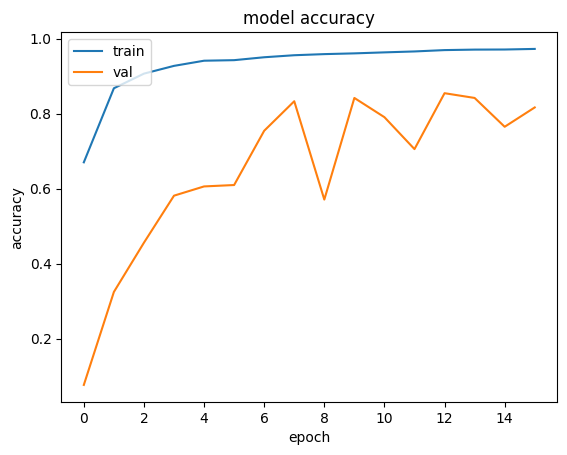

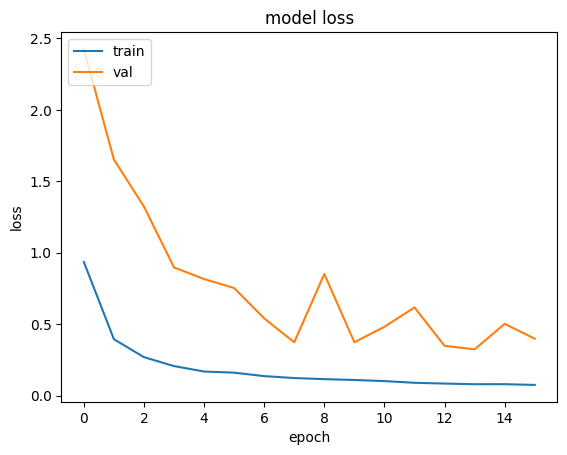

In [31]:
#plot of accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plot of loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
# Now reshape the test set and predict it
X_test_array = np.array(X_test, dtype=np.uint8)
X_test_reshaped = X_test_array.reshape(-1, 28, 28, 3)
loss, acc = model.evaluate(X_test_reshaped, Y_test, verbose=1)

63/63 [==============================] - 1s 13ms/step - loss: 1.1656 - accuracy: 0.7374


63/63 [==============================] - 2s 22ms/step
[[  89    0    0    0    0    0    0]
 [   0  150    0    0    0    0    0]
 [   0    0  206    0    0    0    0]
 [   0    0    0    5    0    0    0]
 [   0    0    0    0 1398    0    0]
 [   0    0    0    0    0   31    0]
 [   0    0    0    0    0    0  124]]


<Axes: >

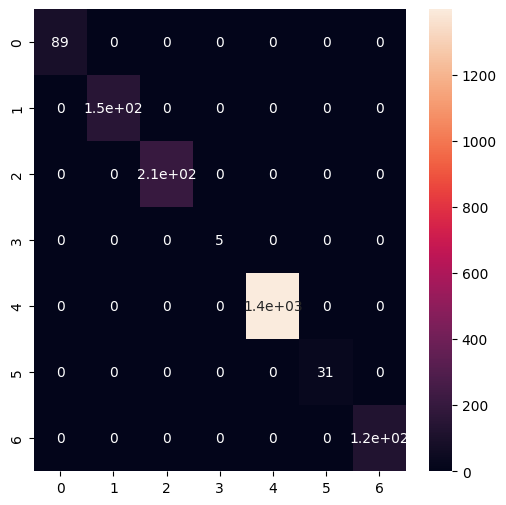

In [33]:
# Evaluate the model with confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(cm, annot=True)

In [ ]:
model.save('Third try.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
